In [1]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from src.ModelClasses import CellType, Water, Solute, Grid, BoundSolute
from src.ModelSetup import Nondimensionalise, CalculateTimestep
from src.TimestepManager import Timestep
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

In [2]:
grid_sizes = [200, 150, 140, 130, 120, 110, 100, 90, 80]

cell_outputs = []
cell_cons_errors = []

for grid_size in grid_sizes:
    nx = grid_size
    ny = grid_size

    # --------------------------------------  MODEL SETUP

    grid = Grid(T = 1e5, L = 3e-3, H = 3e-3, nx = nx, ny = ny, h=1/nx)

    print(grid.h)

    cell = CellType(diffusion_rate = 1e-14, initial_volume_fraction = 0.05, chemotaxis_strength=1.36, bound_chemotaxis_strength=42.4, matrix_drag=9.89e9, matrix_traction=0, contact_inhibition=0.0, aggregation_strength=0)

    water = Water(matrix_volume_fraction=0.03, matrix_drag=5e7)

    solute = Solute(diffusion_rate = 1e-11, initial_solute_concentration = 0, production_rate=8.74e-11, uptake_rate=0, degradation_rate=8.21e-4, binding_rate=1.5e-3)

    bound_solute = BoundSolute(initial_solute_concentration = 0, degradation_rate=8.21e-4, unbinding_rate=3.7e-3)
    
    # Set initial distributions
    
    multiplier = int(nx/10)
    np.random.seed(45) #fix noise distribution to be the same every time
    cell.distribution = cell.initial_volume_fraction + np.random.normal(0, 0.1*cell.initial_volume_fraction, size = (10, 10))
    cell.distribution = np.repeat(cell.distribution, multiplier, axis = 0)
    cell.distribution = np.repeat(cell.distribution, multiplier, axis = 1)
    water.distribution = water.available_volume_fraction - cell.distribution
    
    cell.x_velocity = np.zeros((grid.nx, grid.ny))
    cell.y_velocity = np.zeros((grid.nx, grid.ny))
    
    solute.distribution = solute.uniform_solute_distribution(water, grid)
    bound_solute.distribution = bound_solute.uniform_solute_distribution(water, grid)
    
    initial_cell_distribution = cell.distribution
    initial_solute_distribution = solute.distribution
    
    # Nondimensionalise the input parameters
    
    Nondimensionalise(cell, solute, bound_solute, water, grid, cM = 1e-9, cell_viscosity = 1e4)

    # Set fixed timestep and number of timesteps

    dt = 0.0005
    Tmax = 0.1
    nsteps = int(Tmax/dt)
    print(nsteps)

    # -------------------------------- RUN THE MODEL

    cons_init = np.sum(cell.distribution)

    for t in tqdm(range(nsteps+1)):
        Timestep(cell, solute, bound_solute, water, grid, dt)

    # Calculate conservation error

    cons_final = np.sum(cell.distribution)

    print('cons_error =', (cons_final - cons_init)/cons_init)
    cell_cons_errors.append(np.abs(cons_final - cons_init)/cons_init)

    # Save average cell volume frac for each grid size 

    cell_outputs.append(np.sum(cell.distribution)/(nx*ny))



  0%|          | 0/201 [00:00<?, ?it/s]

0.005
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = -1.3964007183568676e-06
0.006666666666666667
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 1.2829627429745307e-06
0.007142857142857143
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 2.1101042008017835e-06
0.007692307692307693
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 2.6478307990788595e-06
0.008333333333333333
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 5.948809178503132e-06
0.00909090909090909
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 9.618437257180081e-06
0.01
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 1.1744737644451175e-05
0.011111111111111112
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 1.2670129877508983e-05
0.0125
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 1.629755261156033e-05
0.014285714285714285
200


  0%|          | 0/201 [00:00<?, ?it/s]

cons_error = 0.0001417792166546705
0.016666666666666666
200


100%|██████████| 201/201 [03:29<00:00,  1.04s/it]

cons_error = 0.0001744967985588551


In [3]:
cells_grid_error = []
spacing_list = []

for i in range(1, len(grid_sizes)):
    cells_grid_error.append(abs(cell_outputs[i] - cell_outputs[0]) / cell_outputs[0]) 
    spacing_list.append(1/grid_sizes[i])

In [1]:
logspace = np.log(spacing_list)[1:]
logerror = np.log(np.abs(cells_grid_error))

mx = len(spacing_list) - 1

x = np.linspace(np.log(spacing_list[0]), np.log(spacing_list[mx-2]), 100)

Ynint = logspace[0] - 2 * logerror[0]
Yn = Ynint + (2 * x)

NameError: name 'np' is not defined

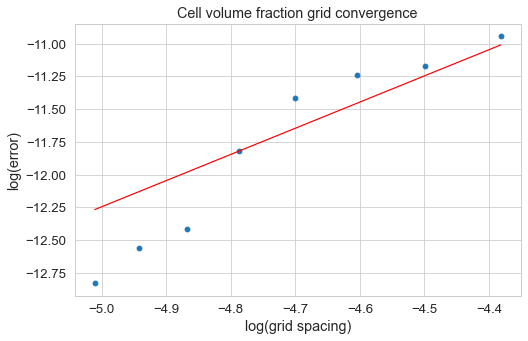

In [14]:
# plot cell volume fraction error against grid spacing only

plt.figure(figsize=(8, 5))
plt.plot(logspace, logerror, 'o')
plt.title('Cell volume fraction grid convergence')
plt.xlabel('log(grid spacing)')
plt.ylabel('log(error)')
plt.plot(x, Yn, 'r')
#plt.savefig('plots/grid_convergence.png', dpi = 300)

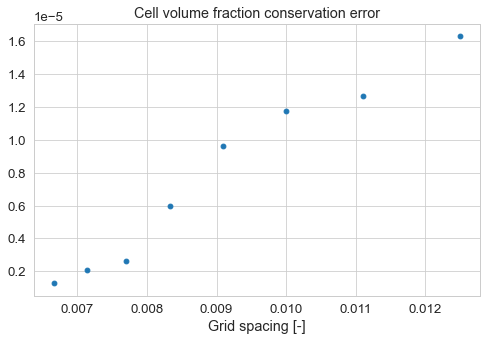

In [16]:
# plot cell_cons_errors

spacing = [1/grid_sizes[i] for i in range(len(grid_sizes))]

plt.figure(figsize=(8, 5))
plt.plot(spacing[:], 100*np.abs(cell_cons_errors)[:], 'o')
plt.title('Cell volume fraction conservation error')
plt.ylabel('Conservation error [%]')
plt.xlabel('Grid spacing [-]')
#plt.savefig('plots/grid_conservation.png', dpi = 300)


In [17]:
with open('plots/optparams_cell_convergence_grid.txt', 'w') as f:
    f.write('log(grid spacing): ' + str(logspace) + '\n')
    f.write('log(errors): ' + str(logerror) + '\n')

In [18]:

with open('plots/optparams_cell_conservation_error_grid.txt', 'w') as f:
    f.write('grid spacings: ' + str(spacing) + '\n')
    f.write('cell_cons_errors (%): ' + str(100*np.abs(cell_cons_errors)))